# Modeling

First thing, I want to see what the simplest, baseline model for my data is. To do this, I will just find whatever I have that correlates the most with PRICE and then create a model with it.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import functions

In [3]:
# Import data
kc = pd.read_csv('../../Data/matthew_clean_data.csv', index_col=0)

In [4]:
# Create Correlation matrix
kc_matrix = kc.corr()
kc_matrix['price']

id             -0.016772
price           1.000000
grade           0.667951
yr_built        0.053953
yr_renovated    0.125499
floors_1.5      0.015896
floors_2.0      0.232696
floors_2.5      0.122845
floors_3.0      0.020036
floors_3.5      0.018132
Name: price, dtype: float64

## Simple Model: Price ~ Grade

In [5]:
# Grade seems to have the highest correlation here. Let's start there

#Train/Test Split
X = kc.drop(columns=['price', 'date', 'yr_renovated'])
y = kc['price']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                 1.140e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:26:53   Log-Likelihood:            -2.0195e+05
No. Observations:               14469   AIC:                         4.039e+05
Df Residuals:                   14467   BIC:                         4.039e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.401e+05   9470.855    -46.472      0.000   -4.59e+05   -4.22e+05
grade       2.107e+05   1973.257    106.783      0.000    2.07e+05    2.15e+05
==============================================================================
Omnibus:                    14116.498   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1820721.199
Skew:                           4.421   Prob(JB):                         0.00
Kurtosis:                      57.239   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# For comparing the models, let's also use our evaluate() function to get R2, RMSE, MAE
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4408
Test R2: 0.4581
****
Train RMSE: $278,960.99
Test RMSE: $261,745.90
****
Train MAE: $176,237.68
Test MAE: $174,783.97


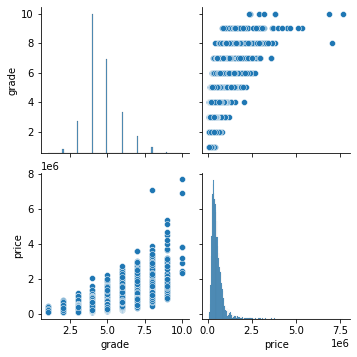

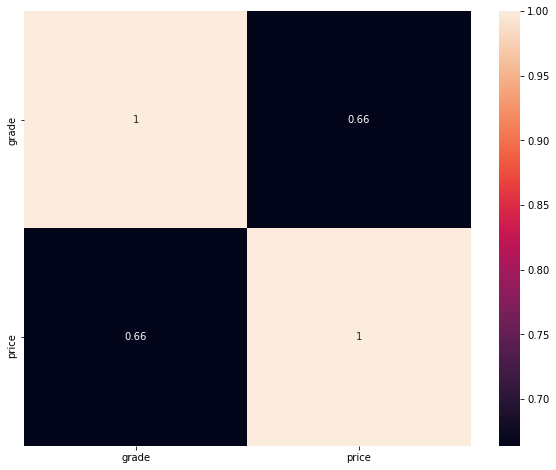

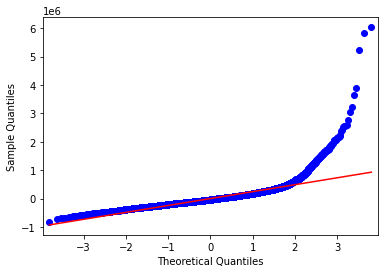

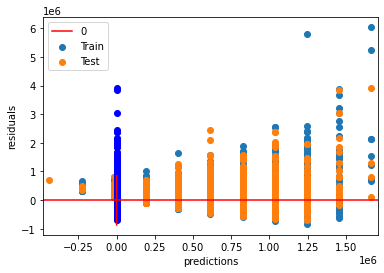

In [7]:
# Let's also check the assumptions of linearity.
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
Looking at the results two things stick out to me:
- The RMSE and MAE have a difference of about $98,000 dollars.

- This model violates the "residual normality" assumption of linear regression. The Jarque-Bera score of 1,991,063 also reinforces this.
- It may also have some heteroscedasticity as well, violating another assumption.

This is definitely a good start, but I think it would benefit any model moving forward to remove the extreme outliers.

## (Price ~ Grade) with removed outliers

In [8]:
# Remove the 5% most expensive houses
kc_trim = kc[kc['price'] < kc['price'].quantile(0.95)]

# Redo the Train/Test Split and exclude outliers
X = kc_trim.drop(columns=['price', 'date', 'yr_renovated'])
y = kc_trim['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train['grade'])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     9235.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:26:58   Log-Likelihood:            -1.8443e+05
No. Observations:               13743   AIC:                         3.689e+05
Df Residuals:                   13741   BIC:                         3.689e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.036e+05   6204.093    -16.696      0.000   -1.16e+05   -9.14e+04
grade       1.281e+05   1332.828     96.100      0.000    1.25e+05    1.31e+05
==============================================================================
Omnibus:                      990.189   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1242.782
Skew:                           0.675   Prob(JB):                    1.36e-270
Kurtosis:                       3.588   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
train_preds = model.predict(sm.add_constant(X_train['grade']))
test_preds = model.predict(sm.add_constant(X_test['grade']))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4019
Test R2: 0.4090
****
Train RMSE: $162,895.43
Test RMSE: $163,246.62
****
Train MAE: $128,650.80
Test MAE: $128,456.90


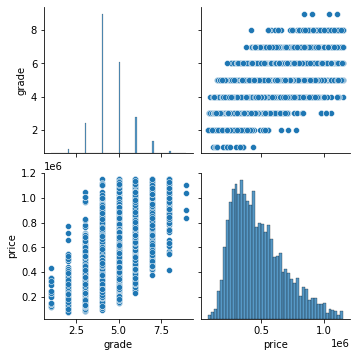

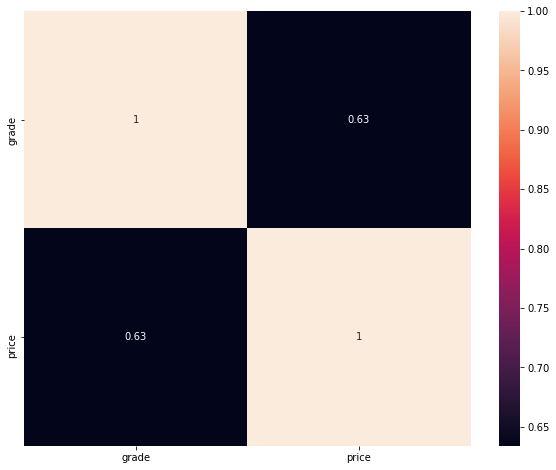

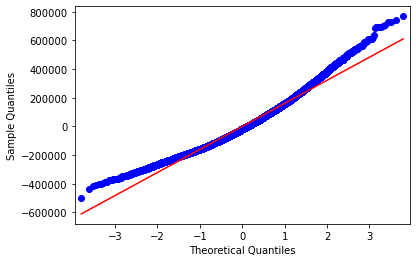

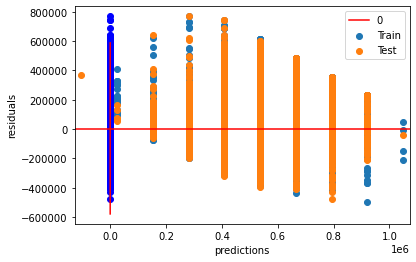

In [10]:
functions.check_assumptions(X_train['grade'], y_train, train_preds, test_preds, y_test)

## Conclusion
This test is interesting:
- The R-Squared went down by about 0.082

but:
- our RMSE went down by about $111,000
- our MSE went down by abour $47,000
- The model still violates the “residual normality” assumption of linear regression. However The Jarque-Bera is now 1270, *much* lower then the previous score of 1,991,063!
- The heteroscedasticity still seems to be present

Overall, I'd say this is an improvement! I think it would be smart to remove outliers like I've done here for any models moving forward. I think it would also be possible to tune the quantile I use to further improve accuracy. For now, I think it'd be better to move on.

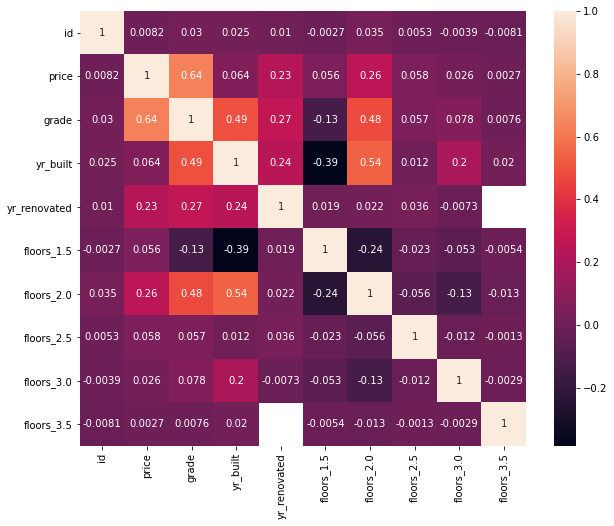

In [11]:
# Before moving forward, I'd like to check the correlation matrix again with removed outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(kc_trim.corr(), annot=True, )
plt.show()

## Renovated
Interestingly, there has been a general uptick in correlations. I think it would be a good idea to investigate the "yr_renovated" column. But let's instead create a column that indicated if a house has been renovated at all, and see if there's any correlation there.

In [12]:
kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)

<ipython-input-12-f37bbce968aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_trim['renovated'] = kc_trim['yr_renovated'].notna().astype(int)


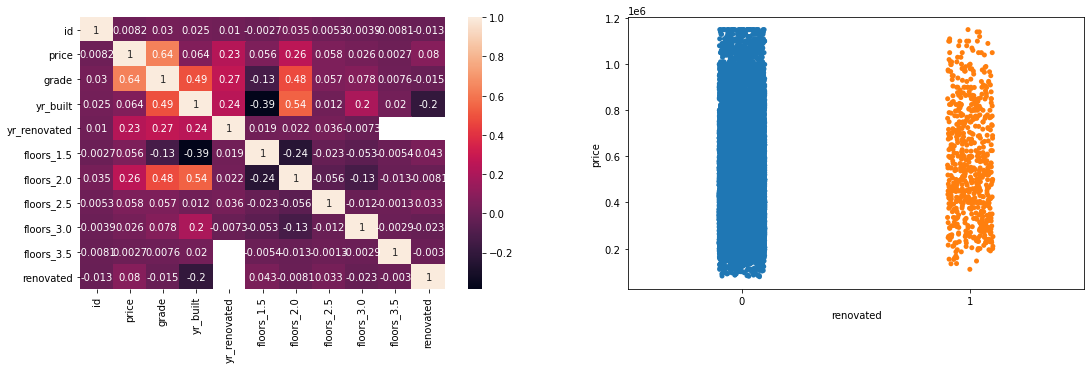

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(kc_trim.corr(), annot=True, ax=ax1)
sns.stripplot(data=kc_trim, x='renovated', y='price', ax=ax2)
plt.show()

an interesting feature, but doesn't look anymore useful then 'yr_renovated'

# Price ~ grade + floors_2.0
I'd like to see if adding 'floors_2.0' to our previous model will result in an improvement.

In [14]:
# No need to re-split since this is a new model
model = sm.OLS(y_train, sm.add_constant(X_train[['grade', 'floors_2.0']])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     4668.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:27:07   Log-Likelihood:            -1.8440e+05
No. Observations:               13743   AIC:                         3.688e+05
Df Residuals:                   13740   BIC:                         3.688e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.195e+05   6519.746    -18.331      0.000   -1.32e+05   -1.07e+05
grade       1.336e+05   1509.739     88.525      0.000    1.31e+05    1.37e+05
floors_2.0 -2.545e+04   3267.416     -7.788      0.000   -3.19e+04    -1.9e+04
==============================================================================
Omnibus:                      980.287   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1231.728
Skew:                           0.669   Prob(JB):                    3.42e-268
Kurtosis:                       3.601   Cond. No.                         23.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
train_preds = model.predict(sm.add_constant(X_train[['grade', 'floors_2.0']]))
test_preds = model.predict(sm.add_constant(X_test[['grade', 'floors_2.0']]))
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.4046
Test R2: 0.4126
****
Train RMSE: $162,537.08
Test RMSE: $162,745.08
****
Train MAE: $128,312.58
Test MAE: $127,855.05


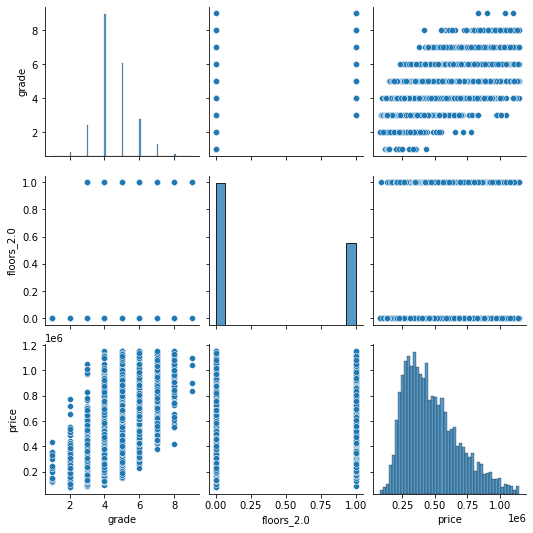

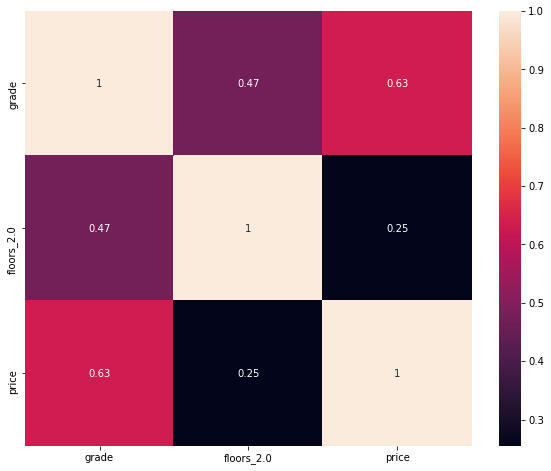

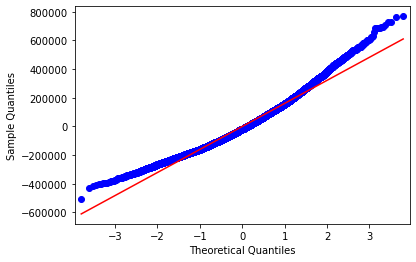

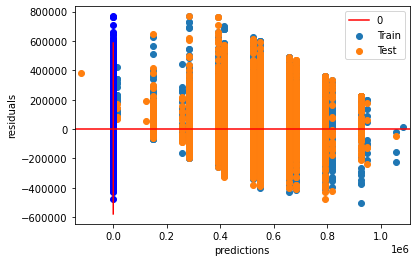

In [16]:
functions.check_assumptions(X_train[['grade', 'floors_2.0']], y_train, train_preds, test_preds, y_test)

## Conclusion
Overall, a **very small** increase in performance across all categories, but it still containes the same issues as the previous model (assumptions of linearity). This is an improvement for sure, however, I think it would be more effective to move on to combining what I have here with some of my partners' models. I think that any more experimintation here would only result in minor increase to performance, as seen in this last model.

In [17]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     1656.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:27:12   Log-Likelihood:            -1.8332e+05
No. Observations:               13743   AIC:                         3.667e+05
Df Residuals:                   13734   BIC:                         3.667e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.984e+06   1.18e+05     42.231      0.000    4.75e+06    5.21e+06
id         -4.438e-07   4.46e-07     -0.994      0.320   -1.32e-06    4.31e-07
grade       1.532e+05   1487.696    102.951      0.000     1.5e+05    1.56e+05
yr_built   -2649.2957     61.017    -43.419      0.000   -2768.897   -2529.694
floors_1.5  2.649e+04   4890.142      5.416      0.000    1.69e+04    3.61e+04
floors_2.0  4.976e+04   3491.336     14.253      0.000    4.29e+04    5.66e+04
floors_2.5  7.867e+04   1.72e+04      4.568      0.000    4.49e+04    1.12e+05
floors_3.0  7.391e+04   8338.656      8.864      0.000    5.76e+04    9.03e+04
floors_3.5  5.782e+04   7.52e+04      0.769      0.442   -8.97e+04    2.05e+05
==============================================================================
Omnibus:                      850.154   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1144.798
Skew:                           0.565   Prob(JB):                    2.57e-249
Kurtosis:                       3.850   Cond. No.                     4.98e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.98e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""